In [31]:
# auto-reload modules when they have changed
%reload_ext autoreload
%autoreload 2

In [32]:
from modules.analyze.blob_detection import BlobDetector
from modules.load import image
from config import config as cfg

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tabulate import tabulate

In [33]:
SOURCE_IMAGE_PATH = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_07_06/control-77K-buffer+glycerol-vitrified/10uW/images/img_control_NaP_100mM_ph7dot5_Glycerol10_10uW_77K_circpol_20um_001.img'

In [34]:
# Load image
im = image.load_from_path(SOURCE_IMAGE_PATH)

In [35]:
image = im.data['preview']

min_intensity = np.amin(image)
max_intensity = np.amax(image)
median_intensity = np.median(image)

# Print the different intensity values
print('Minimum intensity: ', min_intensity)
print('Maximum intensity: ', max_intensity)
print('Median intensity:  ', int(median_intensity))


Minimum intensity:  0
Maximum intensity:  19
Median intensity:   2


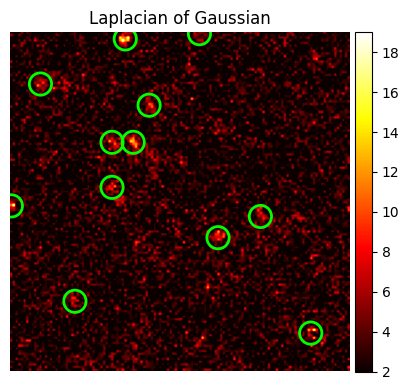

In [36]:
# Initialize blob detector
bd = BlobDetector(input_image=image, blob_type='log')

# Detect blobs
blobs = bd.detect_blobs(min_sigma=3, max_sigma=4, num_sigma=10, threshold=0.005);

# Plot blobs on image
bd.plot_blobs(blobs, vmin=np.median(image))


In [37]:
print(blobs)
blob_data = blobs

[[  2.  43.   3.]
 [ 65.   0.   3.]
 [ 41.  46.   3.]
 [ 77.  78.   3.]
 [ 27.  52.   3.]
 [ 41.  38.   3.]
 [ 19.  11.   3.]
 [ 58.  38.   3.]
 [  0.  71.   3.]
 [ 69.  94.   3.]
 [101.  24.   3.]
 [113. 113.   3.]]


In [38]:
blobs_log = blob_data
blobs = []

image_array = im.data['APD1'] + im.data['APD2']

for blob in blobs_log:
    # Get blob coordinates and radius
    y, x, r = blob

    # Extract blob pixels from original image
    blob_pixels = image_array[int(y - r):int(y + r), int(x - r):int(x + r)]

    if blob_pixels.shape[0] == blob_pixels.shape[1]: 
        blobs.append(blob_pixels)
    else:
        pass



In [39]:
# Create list to store average intensities
avg_intensities = []
max_intensities = []

# Loop over blobs and plot in subplots
for i, blob in enumerate(blobs):
    # Calculate average intensity
    avg_intensity = np.mean(blob)

    # Calculate max intensity
    max_intensity = np.max(blob)

    avg_intensities.append(avg_intensity)
    max_intensities.append(max_intensity)

# Calculate histogram parameters
r_avg_intensities = [round(intensity) for intensity in avg_intensities]
r_max_intensities = [round(intensity) for intensity in max_intensities]

print(r_avg_intensities)
print(r_max_intensities)

[6, 5, 4, 5, 4, 4, 4, 4, 4]
[14, 13, 11, 13, 12, 12, 10, 9, 17]


In [40]:
blob_data = []
for i, blob in enumerate(blobs):
    blob_data.append(['blob_{}'.format(i+1), r_avg_intensities[i], r_max_intensities[i]])

print(blob_data)

# Print the table using the tabulate function
print(tabulate(blob_data, headers=['ID', 'Avg.\nintensity', 'Max.\nintensity'], tablefmt='rst'))

[['blob_1', 6, 14], ['blob_2', 5, 13], ['blob_3', 4, 11], ['blob_4', 5, 13], ['blob_5', 4, 12], ['blob_6', 4, 12], ['blob_7', 4, 10], ['blob_8', 4, 9], ['blob_9', 4, 17]]
======  ===========  ===========
ID             Avg.         Max.
          intensity    intensity
======  ===========  ===========
blob_1            6           14
blob_2            5           13
blob_3            4           11
blob_4            5           13
blob_5            4           12
blob_6            4           12
blob_7            4           10
blob_8            4            9
blob_9            4           17
======  ===========  ===========
